# Portfolio Analysis

In [1]:
from zputils.filesrw.xls import XLS_g_DoDf
from zpanalytics.portfolio.basic import Align_g_Weights_p_Returns, PortfolioReturns_g_Weights_p_Returns_TC
from zpanalytics.returns.drawdowns import Drawdowns_g_R
import pandas as pd
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import scipy
import math

from zpmeta.funcs.func import Func
from pandas.tseries.offsets import BusinessDay

In [2]:
worksp = r"C:\Users\raman\OneDrive\MSx\CMC\Applications\Citadel\Screening"

# set the working directory to the location of the data files
os.chdir(worksp)

## PART 0: Plotting functions

In [3]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

def plot_linechart(drawdowns, title=None, filename=None, pct=True, log=False):
    # plot the drawdowns with nicely formatted dates on the horizontal axis, dates on the x-axis in the format '%Y-%m-%d' tilted at 90 degrees, and the y-axis in percentage format
    if title is None:
        title = 'Drawdowns'
        
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.set_palette('dark')
    sns.set(font_scale=1.5)
    plt.figure(figsize=(36, 12))
    plt.plot(drawdowns)
    
    plt.title(title)
    
    # add legend
    plt.legend(drawdowns.columns)
    
    # add vertical and horizontal gridlines
    plt.grid(True, axis='both', which='both')
    
    # format the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    
    plt.xticks(rotation=45)
    
    # format the y-axis
    if pct:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    if log:
        plt.yscale('log')
    
    # if filename is not None, save the plot to the filename as an HTML file
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
    plt.show()
    
# plot the monthly and annual excess returns as bar charts
def plot_barchart(data, title=None, filename=None, xformat='%Y-%m', width=20, data2=None):
    if title is None:
        title = 'Returns'
        
    # if data is a dataframe, convert it to a series
    # if isinstance(data, pd.DataFrame):
    #     data = data.iloc[:,0]
        
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.set_palette('dark')
    sns.set(font_scale=1.5)
    
    plt.figure(figsize=(36, 12))
    plt.bar(data.index, data, color='steelblue', edgecolor='steelblue', width=width)
    
    plt.title(title)
    
    # format the x-axis but only show the year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(xformat))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    
    # format the y-axis
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(rotation=45)
    
    # add legend
    plt.legend([data.name])
    
    # if data2 is not None, plot it as a line chart with a secondary y-axis using axes
    if data2 is not None:
        ax2 = plt.gca().twinx()
        ax2.plot(data2, color='olivedrab', linewidth=4)
        ax2.set_ylabel(data2.name, color='olivedrab')
        ax2.tick_params(axis='y', labelcolor='olivedrab')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax2.legend([data2.name], loc='upper left')
    
    # add horizontal gridlines
    plt.grid(True, axis='y', which='both')
    
    # add legend for both the y-axis and the secondary y-axis

    
    # if filename is not None, save the plot to the filename as an HTML file
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

# plot the correlation matrix, do not display the diagonal, and format the values to 2 decimal places
def plot_heatmap(correlation, title=None, filename=None):
    if title is None:
        title = 'Correlation Matrix'
        
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.set_palette('dark')
    sns.set(font_scale=1.5)
    
    plt.figure(figsize=(36, 12))
    sns.heatmap(correlation, annot=True, fmt='.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm', square=True)
    plt.title(title)
    
    # if filename is not None, save the plot to the filename as an HTML file
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

## Read the data files

In [15]:
# read the data files
stock_returns = pd.read_excel(f"{worksp}\\{'Data.xlsx'}", sheet_name='Stock Returns', index_col=0, parse_dates=True, header=[0])
factor_returns = pd.read_excel(f"{worksp}\\{'Data.xlsx'}", sheet_name='Factors', index_col=0, parse_dates=True, header=[0])
rfr = factor_returns[['RF']]
factor_returns = factor_returns.drop(columns=['RF'])

portfolio_weights = pd.read_excel(f"{worksp}\\{'Data.xlsx'}", sheet_name='Portfolio Weights', index_col=0, header=[0,1], parse_dates=True)
portfolio_weights.columns = pd.MultiIndex.from_tuples(portfolio_weights.columns, names=['Manager', 'Ticker'])

benchmark_weights = pd.read_excel(f"{worksp}\\{'Data.xlsx'}", sheet_name='Benchmark Weights', index_col=0, header=[0], parse_dates=True)
benchmark_weights.columns = pd.MultiIndex.from_product((['Benchmark'],benchmark_weights.columns), names=['Manager', 'Ticker'])

print(stock_returns.head())
print(factor_returns.head())
print(rfr.head())
print(portfolio_weights.head())
print(benchmark_weights.head())

                AAPL      AMZN     GOOGL       JPM      MSFT      TSLA  \
Ticker                                                                   
2021-12-27  0.022975 -0.008178  0.006738  0.005723  0.023186  0.025248   
2021-12-28 -0.005767  0.005844 -0.008245  0.003035 -0.003504 -0.005000   
2021-12-29  0.000502 -0.008555 -0.000218 -0.000504  0.002051 -0.002095   
2021-12-30 -0.006578 -0.003289 -0.003099 -0.000505 -0.007691 -0.014592   
2021-12-31 -0.003535 -0.011429 -0.009224 -0.000820 -0.008841 -0.012669   

                 TSM         V  
Ticker                          
2021-12-27  0.016738  0.004662  
2021-12-28 -0.005216  0.001930  
2021-12-29 -0.005325  0.000550  
2021-12-30 -0.008154 -0.001375  
2021-12-31 -0.000914 -0.005324  
            Mkt-RF     SMB     HML     RMW     CMA
2021-12-23  0.0071  0.0029 -0.0048 -0.0036 -0.0039
2021-12-27  0.0122 -0.0013  0.0029  0.0097  0.0048
2021-12-28 -0.0027 -0.0041  0.0081  0.0084  0.0020
2021-12-29  0.0006 -0.0003  0.0017  0.0069  0.

## Calculate the portfolio weights & returns

In [17]:
ppweights = Align_g_Weights_p_Returns(dict(returns=stock_returns, portfolio_by=['Manager'], asset_by='Ticker'))(portfolio_weights)
ppweights_benchm = Align_g_Weights_p_Returns(dict(returns=stock_returns, portfolio_by=['Manager'], asset_by='Ticker'))(benchmark_weights)
print(ppweights.tail())
print(ppweights_benchm.tail())

C:\Users\raman\zeroth\zeroth-analytics\zpanalytics\portfolio\basic.py:81: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for plabel, pWeights in portfolio_dict:
C:\Users\raman\zeroth\zeroth-analytics\zpanalytics\portfolio\basic.py:81: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for plabel, pWeights in portfolio_dict:


Manager            0                                                    \
Ticker          AAPL      AMZN     GOOGL       JPM      MSFT      TSLA   
2023-09-26 -0.051920  0.161533  0.079842  0.071378  0.226260  0.187447   
2023-09-27 -0.051770  0.158279  0.079939  0.072121  0.227084  0.189161   
2023-09-28 -0.051137  0.157748  0.080892  0.072300  0.226793  0.185730   
2023-09-29 -0.050674  0.156081  0.081122  0.072425  0.225006  0.188260   
2023-10-02  0.091728 -0.005787 -0.031936  0.250527  0.113619  0.276360   

Manager                                1            ...         3            \
Ticker           TSM         V      AAPL      AMZN  ...       TSM         V   
2023-09-26  0.266803  0.058658  0.263342  0.219235  ...  0.167402 -0.029482   
2023-09-27  0.266248  0.058938  0.262762  0.214966  ...  0.167525 -0.029706   
2023-09-28  0.268974  0.058701  0.261607  0.215942  ...  0.168991 -0.029544   
2023-09-29  0.269153  0.058628  0.259486  0.213866  ...  0.169910 -0.029647   
2023-10

## PART I: Portfolio Analysis

### Calculate basic portfolio statistics

In [18]:
class Performance_g_Returns(Func):
    """Calculate Sharpe given excess returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(rfr=None, periods=12)
        return params

    @classmethod
    def _execute(cls, operand=None, params: dict = None) -> pd.DataFrame:
        if params['rfr'] is None:
            excess_returns = operand.copy()
        else:
            excess_returns = operand.sub(params['rfr'].iloc[:,0], axis=0)
            
        excess_returns = excess_returns.fillna(0.0)

        geometric_mean = scipy.stats.mstats.gmean(1.0 + excess_returns)
        gmean = geometric_mean ** (params['periods']) - 1.0
        stdev = (excess_returns.std(skipna=True)) * math.sqrt(params['periods'])
        sharpe = gmean / stdev
        skew = excess_returns.skew(skipna=True)
        kurtosis = excess_returns.kurtosis(skipna=True)

        result = pd.DataFrame([gmean, stdev, sharpe, skew, kurtosis], index=['GMean Ann', 'STDev Ann', 'Sharpe Ann', 'Skew', 'Kurtosis']).T

        return result
    
class VolAdjust_g_Returns(Func):
    """Calculate Sharpe given excess returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(rfr=None, target_vol=0.12, periods=12)
        return params
    
    @classmethod
    def _execute(cls, operand=None, params: dict = None) -> pd.DataFrame:
        if params['rfr'] is None:
            excess_returns = operand.copy()
        else:
            excess_returns = operand.sub(params['rfr'].iloc[:,0], axis=0)
            
        excess_returns = excess_returns.fillna(0.0)
        
        stdev = excess_returns.std(axis=0)
        
        levered_returns = excess_returns.div(stdev, axis=1) * (params['target_vol']/np.sqrt(params['periods']))
        
        if params['rfr'] is None:
            result = levered_returns
        else:
            result = levered_returns.add(params['rfr'].iloc[:,0], axis=0)
            
        return result

In [19]:
pret = PortfolioReturns_g_Weights_p_Returns_TC(dict(returns=stock_returns, portfolio_by=['Manager'], asset_by='Ticker'))(portfolio_weights)

portfolio_returns_excess = pret['portfolio_returns'].sub(rfr.iloc[:,0], axis=0)

stats_table = Performance_g_Returns(dict(periods=256))(portfolio_returns_excess)
print(stats_table)

   GMean Ann  STDev Ann  Sharpe Ann      Skew  Kurtosis
0  -0.116339   0.299129   -0.388926  0.163682  0.606177
1   0.002128   0.294066    0.007237  0.015165 -0.002264
2  -0.165646   0.310562   -0.533375 -0.218696  1.991446
3   0.115951   0.313889    0.369402 -0.031749  0.682102
4  -0.033282   0.287299   -0.115844  0.212879  1.264489


C:\Users\raman\zeroth\zeroth-analytics\zpanalytics\portfolio\basic.py:81: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for plabel, pWeights in portfolio_dict:


### Drawdowns

In [20]:
drawdowns_total = Drawdowns_g_R({'freq': 'M'})(portfolio_returns_excess)
max_drawdown = drawdowns_total.min()
print("Max Drawdowns\n", max_drawdown)

Max Drawdowns
 Manager
0   -0.420052
1   -0.322509
2   -0.406884
3   -0.294758
4   -0.282502
dtype: float64


### Correlation Analysis

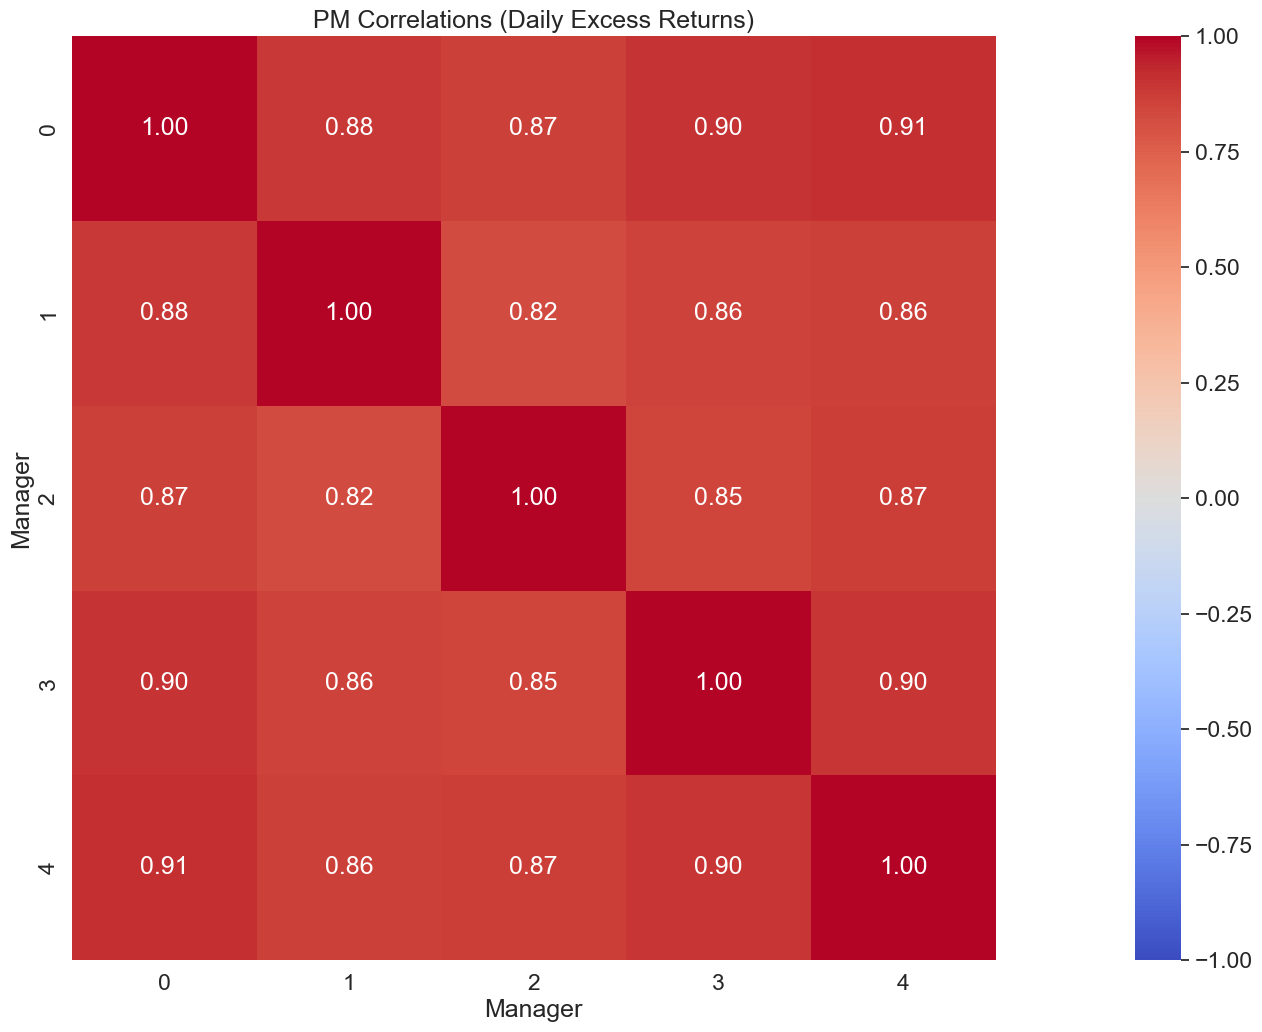

In [21]:
corr = portfolio_returns_excess.corr()
plot_heatmap(corr, title='PM Correlations (Daily Excess Returns)', filename='corr.png')

### Convexity Analysis

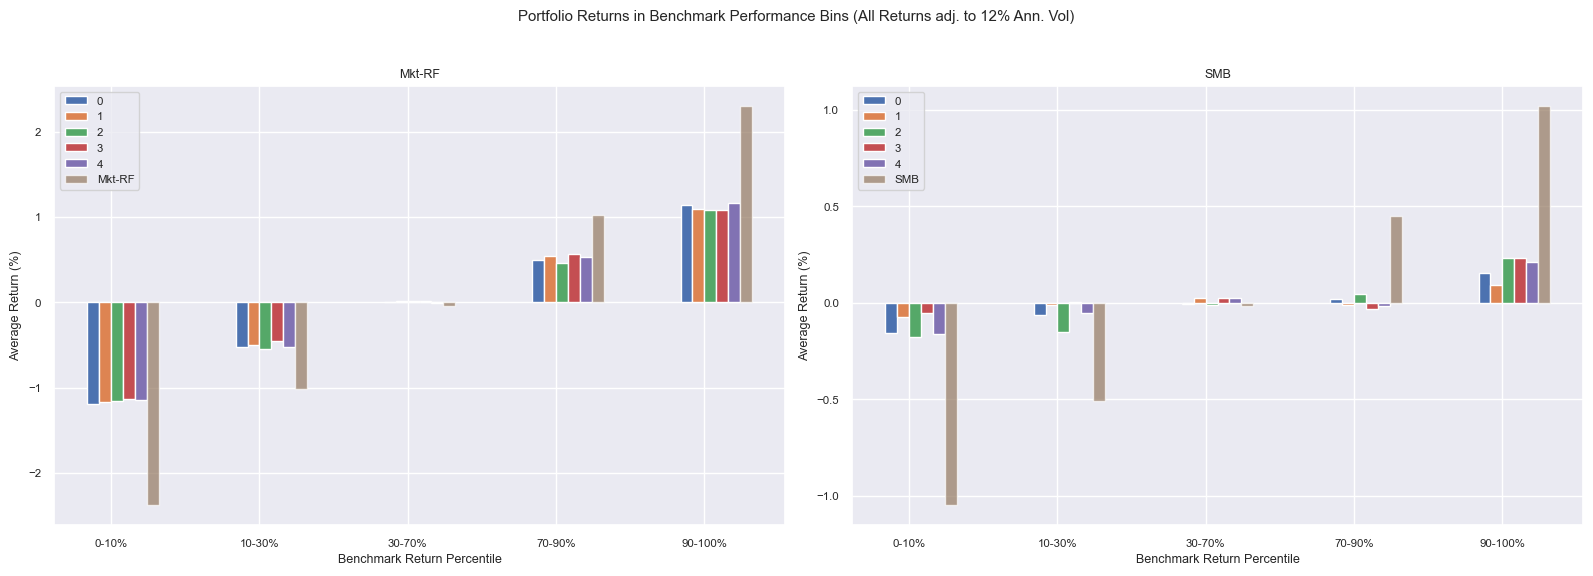

In [22]:
from zpanalytics.returns.basic import Cumulate_g_Returns


class BenchmarkPercentileAnalysis_g_Returns(Func):
    """ Function class for environment analysis.
    """
    @classmethod
    def _std_params(cls, name: str = None) -> dict:
        return dict(freq='M', benchmark_returns=None, percentiles=[10, 30, 70, 90])

    @classmethod
    def _execute(cls, operand: pd.DataFrame = None, params: dict = None) -> object:
        def determine_bin(row, boundaries):
            for i, b in enumerate(boundaries):
                if row < b:
                    return i
            return len(boundaries)
        
        benchmark_label = {k: k for k in params['benchmark_returns'].columns}
        portfolios = list(operand.columns)
        bin_labels = ['0-10%', '10-30%', '30-70%', '70-90%', '90-100%']
        
        sns.set_style('whitegrid')
        sns.set_context('talk')
        sns.set_palette('dark')
        sns.set(font_scale=0.75)
        
        fig, axs = plt.subplots(1, len(benchmark_label), figsize=(8*len(benchmark_label), 6))
        fig.suptitle('Portfolio Returns in Benchmark Performance Bins (All Returns adj. to 12% Ann. Vol)', wrap=True)
        bar_width = 0.40/len(operand.columns)
        
        df = params['benchmark_returns'].join(operand, how='outer')
        df = Cumulate_g_Returns(dict(freq=params['freq']))(df)
        
        records = {}
        for i, benchmark in enumerate(benchmark_label):
            # Calculate percentiles of benchmark returns
            percentiles = np.percentile(df[benchmark], params['percentiles'])
        
            df['bin'] = df[benchmark].apply(lambda x: determine_bin(x, percentiles))
            df['bin_label'] = df['bin'].map(dict(enumerate(bin_labels)))
            
            avg_returns = df.groupby('bin_label').mean()
            
            records[benchmark] = avg_returns
            
            # Creating index for grouped bar chart
            r1 = np.arange(len(avg_returns))
            
            for p, port in enumerate(portfolios):
                rp = [x + (p-1)*bar_width for x in r1]
                axs[i].bar(rp, avg_returns[port] * 100, width=bar_width, label=port)
            
            rb = [x + p*bar_width for x in r1]
            axs[i].bar(rb, avg_returns[benchmark] * 100, width=bar_width, label=benchmark_label[benchmark], alpha=0.7)
            
            #  Plotting for the current benchmark
            axs[i].set_title(f'{benchmark}')
            axs[i].set_xlabel('Benchmark Return Percentile')
            axs[i].set_ylabel('Average Return (%)')
            axs[i].set_xticks([r + bar_width / 2 for r in range(len(avg_returns))])
            axs[i].set_xticklabels(avg_returns.index)
            axs[i].legend()
            axs[i].grid(True, axis='y', which='both')
            
        return records, fig    

voladj_returns = VolAdjust_g_Returns(dict(target_vol=0.12, periods=256))(portfolio_returns_excess)
records, fig = BenchmarkPercentileAnalysis_g_Returns(dict(freq='B', benchmark_returns=factor_returns[['Mkt-RF','SMB']], 
                                                        percentiles=[10, 30, 70, 90]))(voladj_returns)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Results Environment Analysis.png', bbox_inches='tight')
plt.show()

# save the dfexcel 
with pd.ExcelWriter('Results Environments Analysis.xlsx') as writer:
    for benchmark in records:
        records[benchmark].to_excel(writer, sheet_name=benchmark)


In [23]:
import statsmodels.api as sm
import numpy as np

class Convexity_g_Returns(Func):
    """ Function class for convexity analysis.
    """
    @classmethod
    def _std_params(cls, name: str = None) -> dict:
        return dict(benchmark_returns=None, rfr=None, betaShrinkage=1.0, standardize=False, freq='B')

    @classmethod
    def _execute(cls, operand, params=None):
        if params['rfr'] is None:
            excess_returns = operand.copy()
        else:
            excess_returns = operand.sub(params['rfr'].iloc[:,0], axis=0)

        pr_br_ = params['benchmark_returns'].join(excess_returns, how='outer')
        pr_br_ = Cumulate_g_Returns(dict(freq=params['freq']))(pr_br_)
        
        # select portfolio and benchmark returns
        pr_, br_ = pr_br_[excess_returns.columns], pr_br_[params['benchmark_returns'].columns]

        # for each benchmark returns in br_ and each portfolio returns in pr_ calculate the regression coefficients with dummy variable for when the benchmark return is negative
        results = pd.DataFrame()
        for portfolio_label in pr_.columns:
            for benchmark_label in br_.columns:
                # create a dataframe with the benchmark and portfolio returns
                df = pd.DataFrame({'port': pr_[portfolio_label], 'ben': br_[benchmark_label]})
                df = df.dropna()
                
                # create a dummy variable for when the benchmark return is negative
                df['ben_neg'] = df['ben'].apply(lambda x: x if x < 0 else 0)
                
                # create a constant
                df['const'] = 1
                
                # create a regression model
                model = sm.OLS(df['port'], df[['const', 'ben', 'ben_neg']])
                
                # fit the model
                reg_results = model.fit()
                
                # extract the coefficients
                coefficient_df = reg_results.params.to_frame(name=(portfolio_label, benchmark_label, 'Coefficient'))
                pvalue_df = reg_results.params.to_frame(name=(portfolio_label, benchmark_label, 'P-Value'))
                
                df = pd.concat([coefficient_df, pvalue_df], axis=1)
                
                results = pd.concat([results, df], axis=1)

        return results



In [24]:
results = Convexity_g_Returns(dict(freq='B', benchmark_returns=factor_returns[['Mkt-RF','SMB']]))(portfolio_returns_excess)
print(results)

                  0                                           1            \
             Mkt-RF                   SMB                Mkt-RF             
        Coefficient   P-Value Coefficient   P-Value Coefficient   P-Value   
const      0.000168  0.000168   -0.000397 -0.000397    0.000958  0.000958   
ben        1.226615  1.226615    0.366575  0.366575    1.135621  1.135621   
ben_neg    0.036491  0.036491   -0.068871 -0.068871    0.105109  0.105109   

                                        2                                  \
                SMB                Mkt-RF                   SMB             
        Coefficient   P-Value Coefficient   P-Value Coefficient   P-Value   
const      0.000349  0.000349    0.000391  0.000391   -0.000485 -0.000485   
ben        0.115448  0.115448    1.207209  1.207209    0.511722  0.511722   
ben_neg    0.069115  0.069115    0.122715  0.122715   -0.029674 -0.029674   

                  3                                           4           

### Asset-wise Return Contributions

In [25]:
return_contributions = pret['contributed_returns'].sum(axis=0).to_frame(name='Return Contribution').unstack(level='Manager')
print(return_contributions)

        Return Contribution                                        
Manager                   0         1         2         3         4
Ticker                                                             
AAPL               0.032542 -0.026524  0.008631  0.047286  0.006784
AMZN              -0.120653 -0.035917 -0.027465  0.021448 -0.050689
GOOGL             -0.018158 -0.000063 -0.098656  0.081089  0.026090
JPM                0.054020  0.024952  0.000387  0.003163  0.060128
MSFT               0.054300 -0.013077 -0.007267 -0.114728 -0.011069
TSLA               0.036601  0.127100 -0.035526  0.326842  0.013311
TSM               -0.123371  0.074257 -0.098803 -0.135547  0.025052
V                 -0.003911 -0.023228  0.076812  0.095474 -0.008194


### Asset-wise Risk Contribution Analysis

In [26]:
import pandas as pd


class AssetMCTR_g_RBWeights(Func):
    """ Function class for asset-wise risk contribution analysis.
    """
    @classmethod
    def _std_params(cls, name: str = None) -> dict:
        return dict(returns=None, portfolio_weights=None, portfolio_by=['Manager'], asset_by='Ticker', corr_lookback=256)

    @classmethod
    def _execute(cls, operand, params=None):
        pret = PortfolioReturns_g_Weights_p_Returns_TC(dict(returns=params['returns'], portfolio_by=params['portfolio_by'], 
                                                 asset_by=params['asset_by']))(operand)
        
        asset_returns = params['returns']
        
        ppweights_gbo = operand.groupby(by=params['portfolio_by'], axis='columns')
        
        results_dict = dict()
        for portfolio_label, label_ppweights in ppweights_gbo:
            label_ppweights = label_ppweights.dropna(how='all').droplevel(level=params['portfolio_by'], axis='columns')
            
            if len(label_ppweights.columns) > 0:
                asset_returns_label = asset_returns[label_ppweights.columns]
                label_ppweights = label_ppweights.fillna(0.0)
                
                mctr_df = pd.DataFrame()
                for dat in label_ppweights.index:
                    
                    W = label_ppweights.loc[dat]
                    W = W / (W.sum())
                    
                    R = asset_returns_label.truncate(after=dat).iloc[-params['corr_lookback']:]
                    VCV = R.cov()
                    
                    contributed_risk = W.transpose().dot(VCV)
                    contributed_risk = contributed_risk * W
                    
                    total_risk = W.transpose().dot(VCV).dot(W)
                    
                    mctr_day = contributed_risk / total_risk
                    mctr_day_df = mctr_day.to_frame(name=dat).transpose()
                    
                    mctr_df = mctr_df.combine_first(mctr_day_df)
                
                results_dict[portfolio_label] = mctr_df
            
        # combine the results into a single dataframe
        results = pd.concat(results_dict, axis=1, names=['Manager', 'Ticker'])
        
        return results

In [27]:
mctr = AssetMCTR_g_RBWeights(dict(returns=stock_returns, portfolio_by=['Manager'], asset_by='Ticker', 
                                  corr_lookback=256))(portfolio_weights)
print(mctr)

# subset for Manager = 1
mctr_1 = mctr.xs(1, level='Manager', axis='columns')
# print(mctr_1)
# print(mctr_1.sum(axis=1))

C:\Users\raman\zeroth\zeroth-analytics\zpanalytics\portfolio\basic.py:81: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for plabel, pWeights in portfolio_dict:
C:\Users\raman\AppData\Local\Temp\ipykernel_17268\2498234358.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for portfolio_label, label_ppweights in ppweights_gbo:


Manager            0                                                    \
Ticker          AAPL      AMZN     GOOGL       JPM      MSFT      TSLA   
2022-01-01  0.187900 -0.003765  0.102891  0.042786  0.137653  0.327975   
2022-02-01  0.065901  0.097340  0.170556 -0.014213  0.156827  0.528660   
2022-03-01  0.063223  0.206147 -0.056627  0.272008  0.174188  0.094165   
2022-04-01  0.167167  0.131248  0.267652  0.099372  0.079080  0.276321   
2022-05-01  0.123364  0.091970  0.139407  0.108676  0.208609  0.332756   
2022-06-01  0.071893  0.509027  0.118684 -0.003169 -0.086110 -0.105631   
2022-07-01  0.321037 -0.038178  0.155928 -0.013972  0.233641  0.177037   
2022-08-01  0.038064  0.380515  0.179118 -0.038097  0.056553 -0.024251   
2022-09-01  0.051644 -0.041788 -0.080787  0.048630  0.041399  0.326839   
2022-10-01 -0.000105  0.309382  0.112289  0.050285  0.196755  0.134944   
2022-11-01  0.068143  0.360625 -0.029469  0.185390  0.222395  0.141870   
2022-12-01  0.051498  0.266357  0.2432

# PART II: Factor Analysis

## Beta Analysis

In [28]:
class MultiFactorBeta_g_Returns(Func):
    """ Function class for beta analysis.
    """
    @classmethod
    def _std_params(cls, name: str = None) -> dict:
        return dict(benchmark_returns=None, rfr=None, freq='B')

    @classmethod
    def _execute(cls, operand, params=None):
        if params['rfr'] is None:
            excess_returns = operand.copy()
        else:
            excess_returns = operand.sub(params['rfr'].iloc[:,0], axis=0)

        pr_br_ = params['benchmark_returns'].join(excess_returns, how='outer')
        pr_br_ = Cumulate_g_Returns(dict(freq=params['freq']))(pr_br_)
        pr_br_ = pr_br_.dropna(how='any')
        
        # select portfolio and benchmark returns
        pr_, br_ = pr_br_[excess_returns.columns], pr_br_[params['benchmark_returns'].columns]

        X = br_.copy()
        X['const'] = 1
        
        betas = pd.DataFrame()
        regression_results = {}
        for portfolio_label in pr_.columns:
            y = pr_[portfolio_label]
            
            model = sm.OLS(y, X)
            reg_results = model.fit()
            
            # extract the coefficients
            coefficient_df = reg_results.params.to_frame(name=(portfolio_label, 'Coefficient'))
            pvalue_df = reg_results.params.to_frame(name=(portfolio_label, 'P-Value'))
            
            df = pd.concat([coefficient_df, pvalue_df], axis=1)
            
            regression_results[portfolio_label] = reg_results
            betas = pd.concat([betas, df], axis=1)
        
        results = dict(betas=betas, regression_results=regression_results)
        
        return results

In [29]:
# calculate the betas of the portfolios to the market and SMB factors
res = MultiFactorBeta_g_Returns(dict(freq='B', benchmark_returns=factor_returns))(portfolio_returns_excess)
print(res['betas'])

                 0                     1                     2            \
       Coefficient   P-Value Coefficient   P-Value Coefficient   P-Value   
Mkt-RF    1.103658  1.103658    1.043125  1.043125    1.157591  1.157591   
SMB      -0.370824 -0.370824   -0.538500 -0.538500   -0.235549 -0.235549   
HML      -0.001348 -0.001348   -0.050201 -0.050201    0.163254  0.163254   
RMW      -0.095655 -0.095655   -0.111228 -0.111228   -0.131959 -0.131959   
CMA      -0.523591 -0.523591   -0.518293 -0.518293   -0.565348 -0.565348   
const     0.000042  0.000042    0.000486  0.000486   -0.000147 -0.000147   

                 3                     4            
       Coefficient   P-Value Coefficient   P-Value  
Mkt-RF    1.152339  1.152339    1.125710  1.125710  
SMB      -0.410835 -0.410835   -0.313618 -0.313618  
HML       0.017480  0.017480    0.004364  0.004364  
RMW       0.068834  0.068834   -0.037168 -0.037168  
CMA      -0.588122 -0.588122   -0.400631 -0.400631  
const     0.000899  

In [ ]:
# market_cap_pos = portfolio[portfolio['PMWT']>0]
# market_cap_neg = portfolio[portfolio['PMWT']<0]
# market_cap_pos['MKTWT'] = market_cap_pos['MarketCap $B'] / market_cap_pos['MarketCap $B'].sum() # market cap weight
# market_cap_neg['MKTWT'] = -1.0*market_cap_neg['MarketCap $B'] / market_cap_neg['MarketCap $B'].sum() # market cap weight
# portfolio_mkt = pd.concat([market_cap_pos, market_cap_neg])['MKTWT']
# portfolio = portfolio.join(portfolio_mkt, how='left')
# portfolio['MKTWT'].hist()
# # as expected, the market cap weighted portfolio suffers from concentration risk, TECH1 and FINA2 take up 0.57 and -0.37 of the long and short side respectively
# # an empirical solution to this is to use the square root of market cap as the weight
# market_cap_pos = portfolio[portfolio['PMWT']>0]
# market_cap_neg = portfolio[portfolio['PMWT']<0]
# market_cap_pos['MKTWT2'] = market_cap_pos['MarketCap $B'].apply(lambda x: x**0.5) 
# market_cap_neg['MKTWT2'] = -1.0*market_cap_neg['MarketCap $B'].apply(lambda x: x**0.5)
# market_cap_pos['MKTWT2'] = market_cap_pos['MKTWT2'] / market_cap_pos['MKTWT2'].sum()
# market_cap_neg['MKTWT2'] = -1*market_cap_neg['MKTWT2'] / market_cap_neg['MKTWT2'].sum()
# portfolio_mkt2 = pd.concat([market_cap_pos, market_cap_neg])['MKTWT2']
# portfolio = portfolio.join(portfolio_mkt2, how='left')
# portfolio['MKTWT2'].hist()
# # Now this is much better behaved

# rp_pos = portfolio[portfolio['PMWT']>0]
# rp_neg = portfolio[portfolio['PMWT']<0]
# rp_pos['RPWT'] = rp_pos['Total Volatility'].apply(lambda x: 1/x)
# rp_neg['RPWT'] = rp_neg['Total Volatility'].apply(lambda x: 1/x)
# rp_pos['RPWT'] = rp_pos['RPWT'] / rp_pos['RPWT'].sum()
# rp_neg['RPWT'] = -1*rp_neg['RPWT'] / rp_neg['RPWT'].sum()
# portfolio_rp = pd.concat([rp_pos, rp_neg])['RPWT']
# portfolio = portfolio.join(portfolio_rp, how='left')